# All the analysys below refers only to playoff stats

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import xlsxwriter
from openpyxl import load_workbook

from ipynb.fs.full.UtilCollections import SEASONS, PLAYER_STATS, TEAMS
from ipynb.fs.full.UtilFunctions import format_season, spearman_rank_corr

In [11]:
SEASONS = SEASONS[3:]

In [14]:
def calculate_rank_corr_by_player_stat(df, standings, stat, measure="mean"): #measure might be mean, sd or max
    if measure == "mean":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).mean())
    elif measure == "sd":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).std())
    elif measure == "max":
        grouped_df = pd.DataFrame(df.groupby(by=['Tm']).max())
    grouped_df.sort_values(by=[stat, 'Tm'], ascending=[False, True], inplace=True)
    
    teams = list(grouped_df.index)
    if "TOT" in teams:
        teams.remove("TOT")
    rank = range(1, 17)
    teams_ordered_by_stat = dict(zip(teams, rank))

    standings = standings[["Team"]]
    standings.index += 1
    
    standings_dict = dict(zip(list(standings['Team']), standings.index))

    rank1 = []
    rank2 = []
    for team in TEAMS:
        if team in standings_dict:
            rank1.append(teams_ordered_by_stat[team])
            rank2.append(standings_dict[team])

    
    return spearman_rank_corr(rank1, rank2)

In [15]:
def calculate_rank_corr_by_team_stat(df, standings, stat):
    
    corr_df = df.sort_values(by=[stat, 'Team'], ascending=[False, True])
    
    corr_df.set_index('Team', inplace=True)
    
    teams = list(corr_df.index)
    rank = range(1, 17)
    teams_ordered_by_stat = dict(zip(teams, rank))
    
    standings = standings[["Team"]]
    standings.index += 1
    
    standings_dict = dict(zip(list(standings['Team']), standings.index))
        
    rank1 = []
    rank2 = []
    
    for team in TEAMS:
        if team in standings_dict:
            rank1.append(teams_ordered_by_stat[team])
            rank2.append(standings_dict[team])

    return spearman_rank_corr(rank1, rank2)

In [16]:
def rank_player_corrs_to_excel(dfs, standings_dfs, stat, measure="mean"):
    corrs = [stat, measure]
    
    for i in range(len(dfs)):
        corrs.append(calculate_rank_corr_by_player_stat(dfs[i], standings_dfs[i], stat, measure))
        
    wb = load_workbook("DataCollection/Correlation/Rank_Correlation_Player_Stats_Playoffs.xlsx")
    ws = wb.worksheets[0]    
    ws.append(corrs)
    wb.save("DataCollection/Correlation/Rank_Correlation_Player_Stats_Playoffs.xlsx")

In [17]:
def rank_team_corrs_to_excel(dfs, standings_dfs, stat):
    corrs = [stat]
    
    n = len(dfs)
    
    for i in range(n):
        corrs.append(calculate_rank_corr_by_team_stat(dfs[i], standings_dfs[i], stat))
        
    wb = load_workbook("Rank_Correlation_Team_Stats_Playoffs.xlsx")
    ws = wb.worksheets[0]
    
    ws.append(corrs)
    wb.save("Rank_Correlation_Team_Stats_Playoffs.xlsx")

In [18]:
def get_csvs_by_season(season):
    first_year, second_year = format_season(season)
    
    player_df = pd.read_csv("DataCollection/Player_Stats_Playoffs/player_stats_playoffs_{0}-{1}.csv".format(first_year, second_year))
    team_df = pd.read_csv("DataCollection/Team_stats_Playoffs/team_stats_playoffs{0}-{1}.csv".format(first_year, second_year))
    adv_team_df = pd.read_csv("DataCollection/Advanced_Team_Stats_Playoffs/adv_team_stats_Playoffs_{0}-{1}.csv".format(first_year, second_year))
    opponent_df = pd.read_csv("DataCollection/Opponent_Stats_Playoffs/opponent_stats_Playoffs_{0}-{1}.csv".format(first_year, second_year))
    standings_df = pd.read_csv("DataCollection/Standings_Playoffs/playoff_standings_{0}-{1}.csv".format(first_year, second_year))
    return player_df, team_df, adv_team_df, opponent_df, standings_df

In [19]:
player_dfs, team_dfs, adv_team_dfs, opponent_dfs, standings_dfs = [], [], [], [], []

for season in SEASONS:
    player_df, team_df, adv_team_df, opponent_df, standings_df = get_csvs_by_season(season)
    player_dfs.append(player_df)
    team_dfs.append(team_df)
    adv_team_dfs.append(adv_team_df)
    opponent_dfs.append(opponent_df)
    standings_dfs.append(standings_df)

In [20]:
for stat in list(filter(lambda x : x != 'Salary', PLAYER_STATS)):
    for measure in ['mean', 'sd', 'max']:
        rank_player_corrs_to_excel(player_dfs, standings_dfs, stat, measure)

# Player Stats Correlation

In [21]:
playoff_player_corrs_df = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Player_Stats_Playoffs.xlsx")
playoff_player_corrs_df.set_index(["Stat", "Measure"], inplace=True)

In [22]:
reg_season_player_corrs_df = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Player_Stats.xlsx")
reg_season_player_corrs_df.set_index(["Stat", "Measure"], inplace=True)

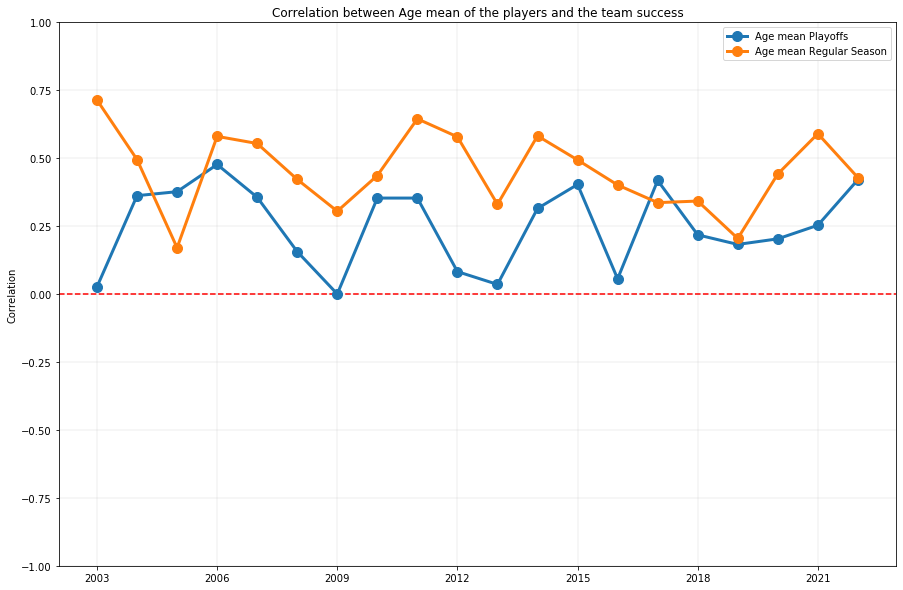

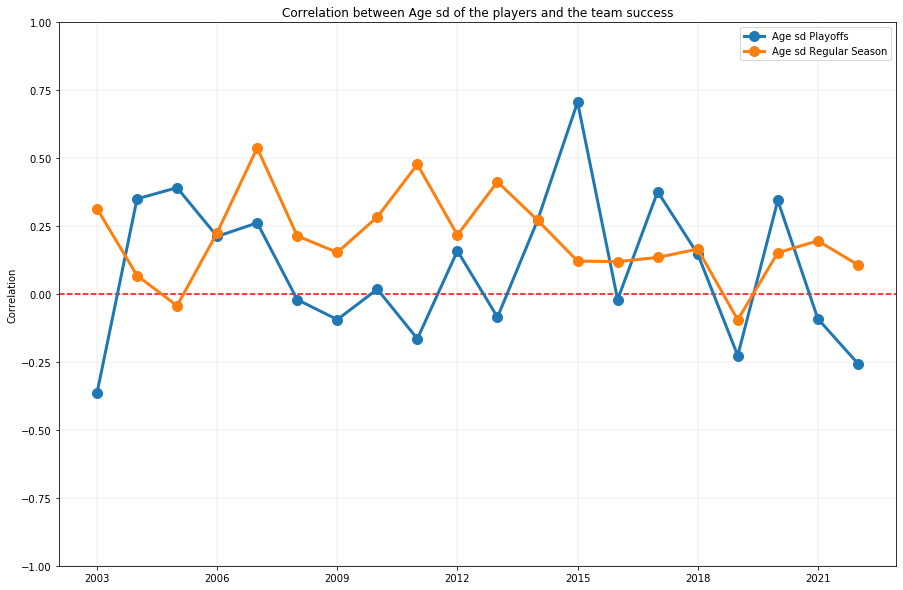

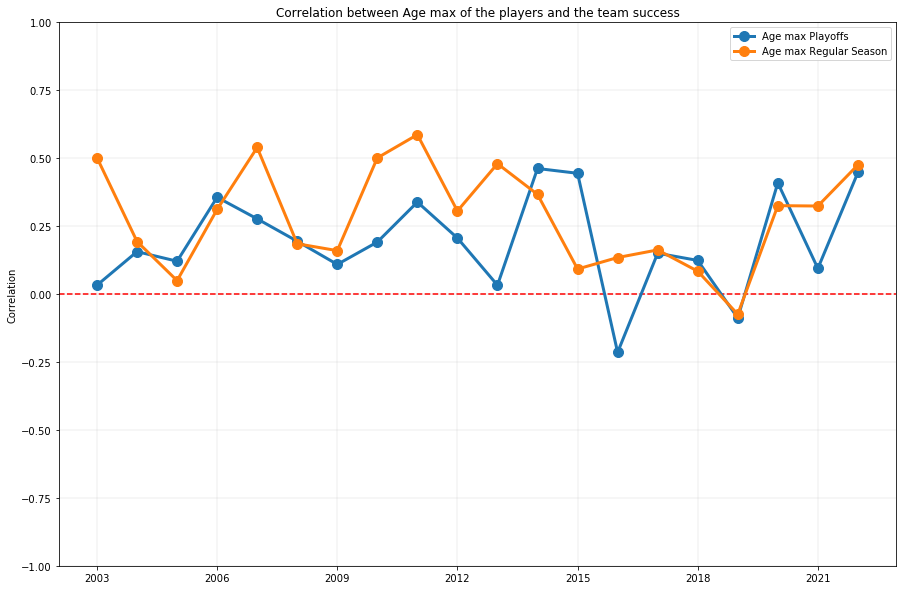

KeyError: 'G'

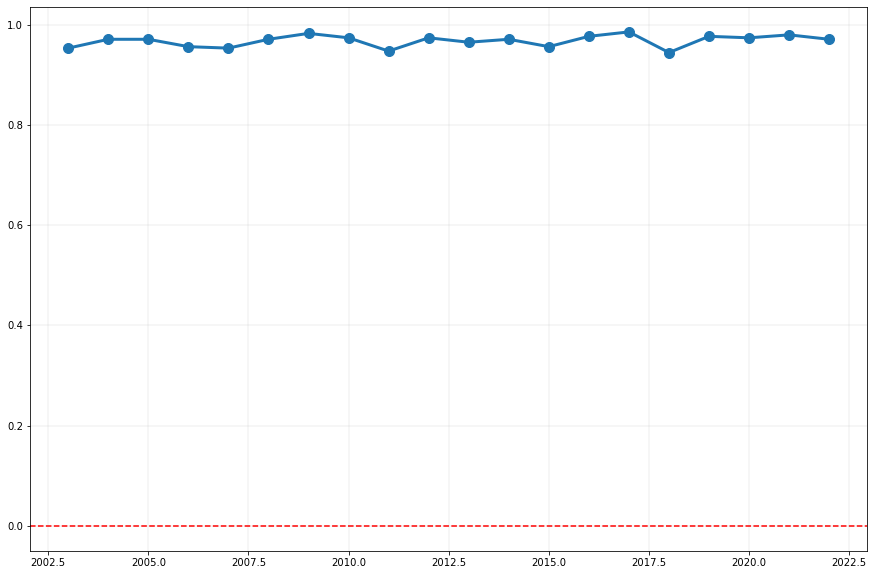

In [23]:
for stat, measure in playoff_player_corrs_df.index:
    plt.figure(figsize=(15,10))
    
    plt.axhline(y=0.0, color='r', linestyle='--')
    plt.grid(lw=0.2)
    plt.plot(SEASONS, playoff_player_corrs_df.loc[stat, measure], lw=3, marker='o', ms=10, label=f'{stat} {measure} Playoffs')
    plt.plot(SEASONS, reg_season_player_corrs_df.loc[stat, measure], lw=3, marker='o', ms=10, label=f'{stat} {measure} Regular Season' )
    plt.xticks(SEASONS[::3])
    plt.yticks(np.arange(-1, 1.1, 0.25))
    plt.ylabel("Correlation")

    plt.title(f"Correlation between {stat} {measure} of the players and the team success")
    plt.legend()
    plt.show()

# Team Stats correlation

In [ ]:
playoff_team_corrs_df = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Team_Stats_Playoffs.xlsx")
playoff_team_corrs_df.set_index(["Stat"], inplace=True)

In [ ]:
reg_season_team_corrs_df = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Team_Stats.xlsx")
reg_season_team_corrs_df.set_index(["Stat"], inplace=True)
reg_season_team_corrs_df = reg_season_team_corrs_df.drop(2022, 1)

In [ ]:
for stat in playoff_team_corrs_df.index:
    plt.figure(figsize=(15,10))
    
    plt.axhline(y=0.0, color='r', linestyle='--')
    plt.grid(lw=0.2)
    plt.plot(SEASONS, playoff_team_corrs_df.loc[stat], lw=3, marker='o', ms=10, label=f'{stat} {measure} Playoffs')
    plt.plot(SEASONS, reg_season_team_corrs_df.loc[stat], lw=3, marker='o', ms=10, label=f'{stat} {measure} Regular Season' )
    plt.xticks(SEASONS[::3])
    plt.yticks(np.arange(-1, 1.1, 0.25))
    plt.ylabel("Correlation")

    plt.title(f"Correlation between {stat} {measure} of the players and the team success")
    plt.legend()
    plt.show()